In [ ]:
!pip install --upgrade tensorflow==2.9.1

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.9.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow import keras
from numba import cuda
from keras.utils import to_categorical
from keras import Sequential
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB7, preprocess_input
from tensorflow.keras.layers import MaxPooling2D,Input,Dense,Flatten,Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,Activation,Lambda,Conv2D
from tensorflow.keras.models import Model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
import gc

In [4]:
main_folder = r"/content/drive/Othercomputers/My Laptop/data/train"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))

['Images with snakes', 'Images without snakes'] 2


In [5]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png") or (file_ext.lower() == "bmp"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)
                    #img_cropped = img[50:200, 50:200]  # Example crop, adjust values as needed

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)
                    
                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)
                    

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 Images with snakes


100%|██████████| 251/251 [01:23<00:00,  2.99it/s]


1 Images without snakes


100%|██████████| 243/243 [01:02<00:00,  3.91it/s]


Total Images Loaded: 2964


In [6]:
images = np.array(images)
labels = np.array(labels) 

np.random.seed(RANDOM_SEED)
n = np.arange(images.shape[0])
np.random.shuffle(n)
images = images[n]
labels = labels[n]

In [7]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
#images = images / 255.0
images = tf.image.resize(images, [IMAGE_SIZE[0], IMAGE_SIZE[1]])
images = images.numpy()
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2964, 224, 224, 3)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (2371, 224, 224, 3)
y_train shape =  (2371,)

x_test shape =  (593, 224, 224, 3)
y_test shape =  (593,)


In [9]:
del labels
del images
gc.collect()

6

In [10]:
EPOCHS = 12
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
L2_RATE = 0.05
DROPOUT_RATE = 0.4

In [11]:
eff_net = EfficientNetB7(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in eff_net.layers:
    layer.trainable = False

258076736/258076736 [==============================] - 1s 0us/step


In [12]:
x = Flatten()(eff_net.output)
x = Dropout(DROPOUT_RATE)(x)
predictions = Dense(TOTAL_CATEGORIES, activation='softmax', kernel_regularizer=regularizers.l2(L2_RATE))(x)
eff_net_model = Model(inputs=eff_net.input, outputs=predictions)
eff_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [13]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=LEARNING_RATE)
eff_net_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

In [15]:
history = eff_net_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch=x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps=y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/12
74/74 [==============================] - 72s 523ms/step - loss: 0.6847 - accuracy: 0.7589 - val_loss: 0.4603 - val_accuracy: 0.8889
Epoch 2/12
74/74 [==============================] - 33s 440ms/step - loss: 0.4913 - accuracy: 0.8777 - val_loss: 0.3922 - val_accuracy: 0.9323
Epoch 3/12
74/74 [==============================] - 33s 445ms/step - loss: 0.4067 - accuracy: 0.9205 - val_loss: 0.3489 - val_accuracy: 0.9549
Epoch 4/12
74/74 [==============================] - 33s 441ms/step - loss: 0.3764 - accuracy: 0.9324 - val_loss: 0.3283 - val_accuracy: 0.9601
Epoch 5/12
74/74 [==============================] - 33s 441ms/step - loss: 0.3322 - accuracy: 0.9577 - val_loss: 0.3112 - val_accuracy: 0.9670
Epoch 6/12
74/74 [==============================] - 33s 441ms/step - loss: 0.3254 - accuracy: 0.9572 - val_loss: 0.2993 - val_accuracy: 0.9688
Epoch 7/12
74/74 [==============================] - 33s 442ms/step - loss: 0.3061 - accuracy: 0.9632 - val_loss: 0.2887 - val_accuracy: 0.9722

In [16]:
loss, accuracy = eff_net_model.evaluate(x_test, y_test, batch_size=32)
print("Efficient Net B7 Loss:", loss)
print("Efficient Net B7 Accuracy:", accuracy*100, "%")

19/19 [==============================] - 8s 395ms/step - loss: 0.2611 - accuracy: 0.9747
Efficient Net B7 Loss: 0.2611003518104553
Efficient Net B7 Accuracy: 97.47048616409302 %


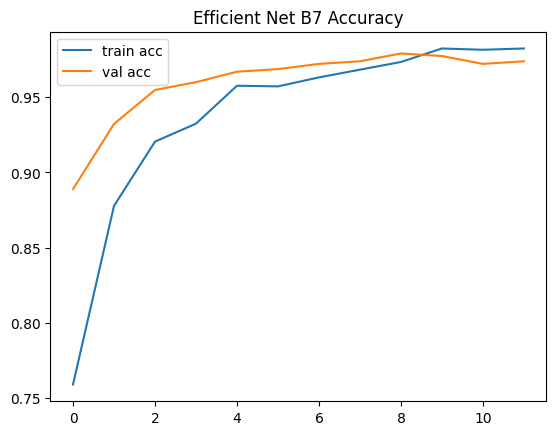

In [17]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Efficient Net B7 Accuracy")
plt.legend()
plt.show()

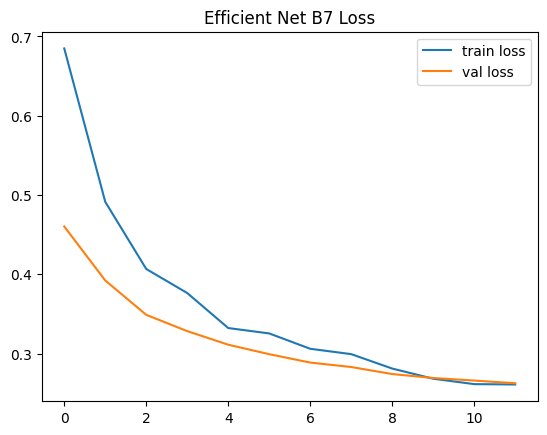

In [18]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Efficient Net B7 Loss")
plt.legend()
plt.show()

In [19]:
#predict
y_pred=eff_net_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

19/19 [==============================] - 12s 335ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       283
           1       0.97      0.98      0.98       310

    accuracy                           0.97       593
   macro avg       0.97      0.97      0.97       593
weighted avg       0.97      0.97      0.97       593



In [20]:
eff_net_model.save("Snake_detection_effnet_9.h5", save_format="h5")

In [22]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

new_model = load_model('Snake_detection_effnet_9.h5')
IMAGE_SIZE = (224, 224, 3)
unTrainDataDir = r"/content/drive/Othercomputers/My Laptop/data/test"

n = 0
fig = plt.figure(figsize=(16, 32))
for pic in os.listdir(unTrainDataDir):
    imgPath = os.path.join(unTrainDataDir, pic)
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    n += 1
    plt.subplot(18, 4, n)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    check = new_model.predict(np.expand_dims(img, axis=0))
    if check[0][0] > 0.5:
        plt.title("Snake present")
    else:
        plt.title("No Snake")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.